# Only probdiffeq-solvers

Let's find the fastest solver of the Lotka-Volterra problem, a standard benchmark problem. It is low-dimensional, not stiff, and generally poses no major problems for any numerical solver.

In [1]:
import functools

import jax
import jax.experimental.ode
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax import config

from probdiffeq import controls, ivpsolvers
from probdiffeq.doc_util import benchmark, info, notebook, workprecision
from probdiffeq.statespace import cubature, recipes
from probdiffeq.strategies import filters, smoothers

In [2]:
# x64 precision
config.update("jax_enable_x64", True)

# CPU
config.update("jax_platform_name", "cpu")

# IVP examples in JAX
if not backend.has_been_selected:
    backend.select("jax")

# Nice-looking plots
plt.rcParams.update(notebook.plot_config())

# Which version of the softwares are we using?
info.print_info()


ProbDiffEq version:
	0.1.5.dev54+dirty
Diffrax version:
	0.3.1
SciPy version:
	1.10.1

Most recent ProbDiffEq commit:
	b'8c4472\n'

jax:    0.4.4
jaxlib: 0.4.4
numpy:  1.24.2
python: 3.10.6 (main, Mar 10 2023, 10:55:28) [GCC 11.3.0]
jax.devices (1 total, 1 local): [CpuDevice(id=0)]
process_count: 1


This is the ODE problem:

In [3]:
# Make a problem
f, u0, (t0, t1), f_args = ivps.lotka_volterra(time_span=(0.0, 50.0))


@jax.jit
def vf(x, *, t, p=()):
    return f(x, *f_args)


problem = benchmark.FirstOrderIVP(vector_field=vf, initial_values=(u0,), t0=t0, t1=t1)

# Compute a reference solution
ts = jnp.linspace(t0, t1, num=250)
problem_jax = problem.to_jax(t=ts)
odeint_solution = jax.experimental.ode.odeint(
    *problem_jax.args, **problem_jax.kwargs, atol=1e-12, rtol=1e-12
)


# Select all remaining problem parameters
rtols = 0.1 ** jnp.arange(1.0, 11.0, step=2.0)
atols = 1e-2 * rtols
num_repeats = 5
error_fn = benchmark.relative_rmse(solution=odeint_solution[-1, :])
solve_fn = benchmark.probdiffeq_terminal_values()

# Bundle the problem setup
problem_config = workprecision.ProblemConfig(
    label="Lotka-Volterra (terminal-value simulation)",
    problems=problem,
    error_fn=error_fn,
    solve_fns=solve_fn,
    atols=atols,
    rtols=rtols,
    repeat=num_repeats,
)

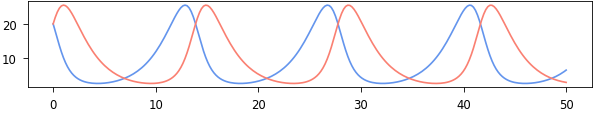

In [4]:
# Plot the solution
fig, ax = plt.subplots(figsize=(5, 1))
ax.plot(ts, odeint_solution, marker="None")
plt.show()

## Internal solvers
Let's start with finding the fastest probabilistic IVP solver.


In [5]:
# Some helper functions


def impl_to_method_config(impl, *, label):
    return strategy_to_method_config(filters.Filter(*impl), label=label)


def strategy_to_method_config(strategy, *, label):
    solver = ivpsolvers.MLESolver(strategy)
    return workprecision.MethodConfig(method=solver_to_method(solver), label=label)


def solver_to_method(solver):
    return {
        "solver": solver,
        "control": controls.ProportionalIntegral(),
    }

### Which mode of linearization?

Should we linearize with a Taylor-approximation or by moment matching?

In [6]:
def cubature_to_slr1(cubature_rule_fn, *, ode_shape):
    return recipes.slr1_dense(
        ode_shape=ode_shape,
        cubature_rule_fn=cubature_rule_fn,
    )


# Different linearisation styles
ode_shape = u0.shape
ts1 = recipes.ts1_dense(ode_shape=ode_shape)
sci_fn = cubature.third_order_spherical
ut_fn = functools.partial(cubature.unscented_transform, r=1.0)
gh_fn = functools.partial(cubature.gauss_hermite, degree=3)
slr1_sci = cubature_to_slr1(sci_fn, ode_shape=ode_shape)
slr1_ut = cubature_to_slr1(ut_fn, ode_shape=ode_shape)
slr1_gh = cubature_to_slr1(gh_fn, ode_shape=ode_shape)


# Methods
methods = [
    impl_to_method_config(impl=ts1, label="TS1()"),
    impl_to_method_config(impl=slr1_sci, label="SLR1(SCI)"),
    impl_to_method_config(impl=slr1_ut, label="SLR1(UT)"),
    impl_to_method_config(impl=slr1_gh, label="SLR1(GH)"),
]

In [7]:
results = workprecision.create(problem=problem_config, methods=methods)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

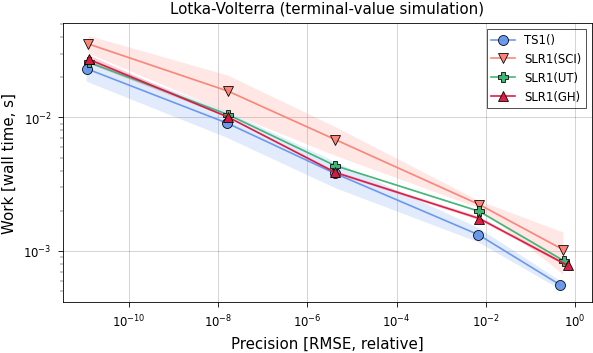

In [8]:
fig, ax = plt.subplots(figsize=(5, 3))
fig, ax = workprecision.plot(
    results=results, fig=fig, ax=ax, title=problem_config.label
)
plt.show()

The Taylor-series based method is more efficient. The cubature rule has little effect on the efficiency of the moment-matching solver.

### Which factorisation?

What is the performance difference between an isotropic, block-diagonal, and dense covariances in the state-space model?

In [9]:
# Different factorisations
ts0_iso = recipes.ts0_iso()
ts0_batch = recipes.ts0_blockdiag(ode_shape=ode_shape)
ts0_dense = recipes.ts0_dense(ode_shape=ode_shape)

# Methods
methods = [
    impl_to_method_config(ts0_iso, label="IsoTS0()"),
    impl_to_method_config(ts0_batch, label="BatchTS0()"),
    impl_to_method_config(ts0_dense, label="DenseTS0()"),
]

In [10]:
results = workprecision.create(problem=problem_config, methods=methods)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

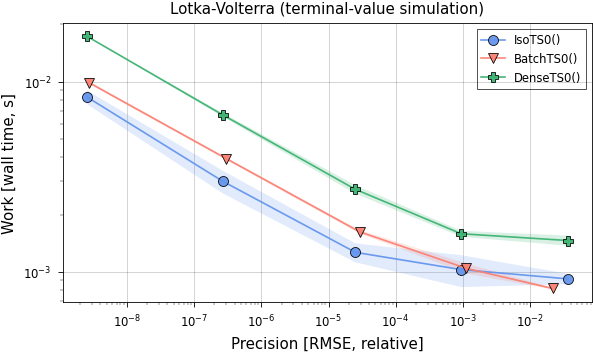

In [11]:
fig, ax = plt.subplots(figsize=(5, 3))
fig, ax = workprecision.plot(
    results=results, fig=fig, ax=ax, title=problem_config.label
)
plt.show()

Unsurprisingly, the stronger the factorisation, the faster. The isotropic solver is the fastest, the batch-solver is second place, and the dense solver is the slowest (by far).
The isotropic solver and the dense solver actually compute the same posterior (the errors are vertically aligned), but at different speeds.

### Should I use a filter or a smoother?

In [12]:
# Methods
impl = recipes.ts0_iso()
methods = [
    strategy_to_method_config(filters.Filter(*impl), label="Filter"),
    strategy_to_method_config(smoothers.Smoother(*impl), label="Smoother"),
    strategy_to_method_config(
        smoothers.FixedPointSmoother(*impl), label="FixedPointSmoother"
    ),
]

In [13]:
results = workprecision.create(problem=problem_config, methods=methods)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

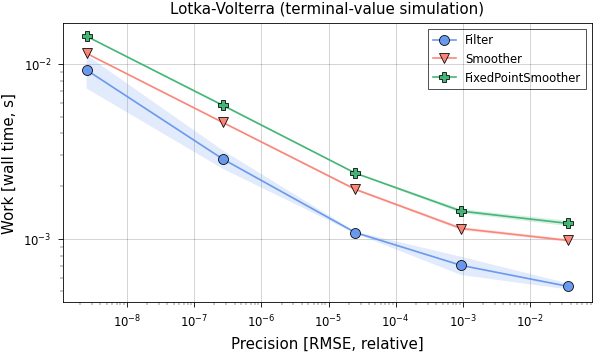

In [14]:
fig, ax = plt.subplots(figsize=(5, 3))
fig, ax = workprecision.plot(
    results=results, fig=fig, ax=ax, title=problem_config.label
)
plt.show()

The filter is the fastest, the smoother is second, and the fixed-point smoother is the slowest.
But this is unsurprising, because the smoother and the fixed-point smoother compute extra quantities that the filter ignores.
These extra quantities make the smoothing solutions a valid posterior distribution at all time-points, whereas the filtering distribution makes sense mostly at the terminal value.

But when the quantitity of interest is the terminal value, filters are the go-to strategy.



### Fastest methods

So what are the fastest solvers?
We know that filters are better than smoothers for terminal-value simulation.
We also know that isotropic, zeroth-order approximations are the fastest zeroth-order methods,
and that Taylor-series based linearisations outperform moment matching.
We know that the dynamic solver is superior over the non-dynamic solver for low order methods with first-order linearisation, and that the is preferrable in the other setups (sometimes only incrementally).

Let's compare the winning solvers to find the best one.

In [15]:
# Implementations
num_low, num_medium, num_high = 3, 5, 8

ts0_iso_low = recipes.ts0_iso(num_derivatives=num_low)
ts0_iso_medium = recipes.ts0_iso(num_derivatives=num_medium)

ts1_low = recipes.ts1_dense(ode_shape=ode_shape, num_derivatives=num_low)
ts1_medium = recipes.ts1_dense(ode_shape=ode_shape, num_derivatives=num_medium)
ts1_high = recipes.ts1_dense(ode_shape=ode_shape, num_derivatives=num_high)

slr1_high = recipes.slr1_dense(ode_shape=ode_shape, num_derivatives=num_high)

# Methods
methods = [
    impl_to_method_config(ts0_iso_low, label=f"IsoTS0({num_low})"),
    impl_to_method_config(ts0_iso_medium, label=f"IsoTS0({num_medium})"),
    impl_to_method_config(ts1_low, label=f"DenseTS1({num_low})"),
    impl_to_method_config(ts1_medium, label=f"DenseTS1({num_medium})"),
    impl_to_method_config(ts1_high, label=f"DenseTS1({num_high})"),
    impl_to_method_config(slr1_high, label=f"DenseSLR1({num_high})"),
]

In [16]:
results = workprecision.create(problem=problem_config, methods=methods)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

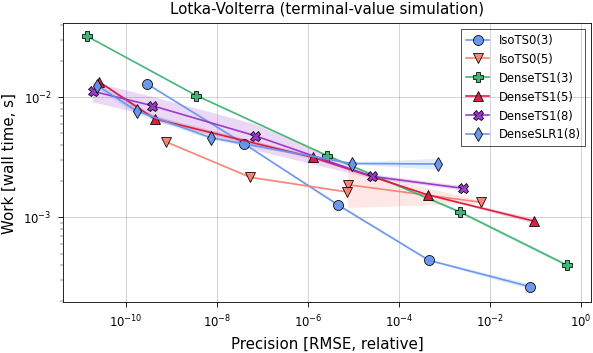

In [17]:
fig, ax = plt.subplots(figsize=(5, 3))
fig, ax = workprecision.plot(
    results=results, fig=fig, ax=ax, title=problem_config.label
)
plt.show()

## Conclusion

If these results show one thing, then the fact that it is worth building a specialised ODE solver
for simulate_terminal_values(). The smoothing-based solvers compute extra factors that are just not needed for terminal-value simulation, and the extra factors turn out to be quite expensive. Every smoother was slower than its filtering-equivalent.

We can observe more:
* Low precision is best achieved with an IsoTS0 and a number of derivatives smaller than 5. High precision is best achieved with a DenseTS1 and a number of derivatives larger than 5. The middle ground is better covered by an IsoTS0 than a DenseTS1.
* The cubature filters are more expensive than the Taylor-series filters (presumably, because cubature-linearisation costs more than Taylor-linearisation)